In [1]:
import sys
import os
import random
import pickle
import numpy as np
from preprocessing import make_delayed
from preprocessing import downsample_word_vectors
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

# Add the root project folder to sys.path (so ridge_utils becomes importable)
project_root = os.path.abspath('..')  # moves up from 'code/'
sys.path.append(project_root)

In [2]:
# Load the raw_text.pkl file
path_to_data = '/ocean/projects/mth240012p/shared/data'
with open(f'{path_to_data}/raw_text.pkl', 'rb') as f:
    raw_text = pickle.load(f)

print(type(raw_text))
print(len(raw_text)) # total 109 stories


<class 'dict'>
109


Before splitting the stories into train and test, since there are 8 more stories in the raw_text file than in the stories in subject 2 and 3, we exclude these stories since they cannot be used for both test or train. 

In [3]:
all_stories = set(raw_text.keys())
subj2_stories = set(os.path.splitext(f)[0] for f in os.listdir(f'{path_to_data}/subject2') if f.endswith('.npy'))
subj3_stories = set(os.path.splitext(f)[0] for f in os.listdir(f'{path_to_data}/subject3') if f.endswith('.npy'))
print(subj2_stories == subj3_stories) #fortunately, subject 2 and 3 has same stories
valid_stories = sorted(list(all_stories & subj2_stories & subj3_stories))
print(len(valid_stories)) 

True
101


Now we split test stories, train stories (3:7)

In [4]:
#we will just rename valid_stories as all_stories for the sake of simplicity.
all_stories = valid_stories
random.seed(42)
random.shuffle(all_stories)
split_idx = int(0.7 * len(all_stories))  # 70% for training

train_stories = all_stories[:split_idx]
test_stories = all_stories[split_idx:]

print(f"Train stories: {len(train_stories)}")
print(f"Test stories: {len(test_stories)}")
train_stories.sort()
test_stories.sort()

Train stories: 70
Test stories: 31


In [5]:
#compute and append all words in train_stories
allwords = []
for story in train_stories:
    temp_text = raw_text[story].data
    allwords += temp_text

print(len(allwords))

#compute unique words in train_stories
unique_words = list(set(allwords))
len(unique_words)

137105


10360

In [6]:
#define function that returns matrix given word_list, 
#vector_size = 300 which is from the pretrained model

def embed_story_words(word_list, model, vector_size):
    embedded = []
    for word in word_list:
        if word in model:
            embedded.append(model[word])
        else:
            embedded.append(np.zeros(vector_size))  # unknown word
    return np.vstack(embedded)

**GloVe method** 
Basically we do the same as the two methods above. 


In [7]:
#Download a pre-trained GloVe file in https://nlp.stanford.edu/projects/glove/
#glove.6B.zip <- unzip this file and MOVE the glove.6B.300d.txt to DATA folder

#Since glove file is txt file, we will manually make a dictionary, glove_dict
#whose keys are words and values are 300 dim. vectors corresponding for each word of Glove Model. 
glove_file = '../data/glove.6B.300d.txt'

glove_dict = {}
with open(glove_file, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = [float(val) for val in values[1:]]
        glove_dict[word] = vector

In [8]:
in_model = [word for word in unique_words if word in glove_dict]
not_in_model = [word for word in unique_words if word not in glove_dict]
print(f"Percentage of words Not in glv model: {len(not_in_model)/len(unique_words):.4f}")

Percentage of words Not in glv model: 0.0427


In [9]:
vector_size = 300 #of pretrained model (Glove)
story_vectors_glv = {} 

for story in train_stories:
    words = raw_text[story].data
    story_vectors_glv[story] = embed_story_words(words, glove_dict, vector_size)

2. Downsample and trim matrices

In [10]:
wordseqs = {story: raw_text[story] for story in train_stories}
downsampled_vectors_3 = downsample_word_vectors(
    stories=train_stories,
    word_vectors=story_vectors_glv,
    wordseqs=wordseqs
)

trimmed_vectors_3 = {} #trimmed matrices for each train story 

for story, matrix in downsampled_vectors_3.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_3[story] = trimmed_matrix

3. Creating lagged version of matrices

Same as W2V, 300 * 4 =1200 will be the number of columns.

In [11]:
delayed_vectors_3 = {}

for story, trimmed_matrix in trimmed_vectors_3.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_3[story] = X_lagged

In [12]:
vector_size = 300 #of pretrained model (Glove)
story_vectors_glv_test = {} 

for story in test_stories:
    words = raw_text[story].data
    story_vectors_glv_test[story] = embed_story_words(words, glove_dict, vector_size)

wordseqs2 = {story: raw_text[story] for story in test_stories} #wordseqs for test stories 
downsampled_vectors_3_test = downsample_word_vectors(
    stories=test_stories,
    word_vectors=story_vectors_glv_test,
    wordseqs=wordseqs2
)

trimmed_vectors_3_test = {} #trimmed matrices for each test story 

for story, matrix in downsampled_vectors_3_test.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_3_test[story] = trimmed_matrix

delayed_vectors_3_test = {}

for story, trimmed_matrix in trimmed_vectors_3_test.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_3_test[story] = X_lagged

print(len(delayed_vectors_3_test))
#check for first matrix for story
for key, value in delayed_vectors_3_test.items():
    print("First key:", key)
    print("delayed matrix for first story is", value.shape)
    break

31
First key: adollshouse
delayed matrix for first story is (241, 1200)


In [13]:
#check if dimensions match with response matrix
story_s2 = np.load(f"{path_to_data}/subject2/adollshouse.npy")
print("Shape:", story_s2.shape)

Shape: (241, 94251)


In [14]:
import gc
del glove_dict
del raw_text
gc.collect()

11

PART2

**Subject2**

In [15]:
from ridge_utils.ridge import ridge_corr, ridge_corr_pred
import numpy as np
import logging
from ridge_utils.ridge import ridge_corr
from ridge_utils.utils import mult_diag
import random
from sklearn.model_selection import KFold

In [16]:
path_s2 = '/ocean/projects/mth240012p/shared/data/subject2/'
Y_s2_train_dict = {}
for story in train_stories:
    Y_s2_train_dict[story] = np.load(path_s2 + f"{story}.npy")
Y_s2_test_dict = {}
for story in test_stories:
    Y_s2_test_dict[story] = np.load(path_s2 + f"{story}.npy")

In [17]:
#Test for w2v, subject 2
# Stack X to make matrix
X_train_full = np.vstack([delayed_vectors_3[s] for s in train_stories]) 
X_test_full = np.vstack([delayed_vectors_3_test[s] for s in test_stories])    

# Stack Y2 to make one matrix
Y_train_s2 = np.vstack([Y_s2_train_dict[s] for s in train_stories])
Y_test_s2 = np.vstack([Y_s2_test_dict[s] for s in test_stories])

2(1). First we fit ridge regression. 

Since we don't know the alphas(hyperparameters) yet, we try with alpha = 1 for all voxels. 

In [18]:
logging.basicConfig(level=logging.INFO)
ridge_logger = logging.getLogger("ridge_corr")
zs = lambda v: (v - v.mean(0)) / v.std(0)

X_train_full = zs(X_train_full)
X_test_full = zs(X_test_full)
Y_train_s2 = zs(Y_train_s2)
Y_test_s2 = zs(Y_test_s2)

#subject 2
num_vox_s2 = 94251
corr_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas= np.ones(num_vox_s2))
mean_cc_2 = np.mean(corr_s2[np.isfinite(corr_s2)]) #exclude
print("Mean CC for sub2:", mean_cc_2)
#We can see that when alphas are poorly set, the mean CC across voxels are very low. 

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24955, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1484.407
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean CC for sub2: 0.005922470137439424


2(1). CV 

We use 5-fold CV to get best alphas for each voxel. 

In [19]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(1, 4, 10)  # 10 values from 10 to 10000
Rcorrs_folds = []  # Store Rcorrs for each fold

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for glv")

    # Get the story names for this fold
    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_3[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_3[s] for s in val])      
    Y_train = np.vstack([Y_s2_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s2_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 94251)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 94251)
# Select best alpha for each voxel
best_alpha_idx_s2 = np.argmax(Rcorrs_5foldmean, axis=0)  # (94251,)
valphas_s2 = alphas[best_alpha_idx_s2]  # (94251,)


Processing fold 1/5 for glv


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19805, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1307.352
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00306, max corr=0.08383, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00344, max corr=0.08710, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00401, max corr=0.09270, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00512, max corr=0.11017, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00698, max corr=0.12824, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00873, max corr=0.12984, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.00912, max corr=0.12329, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00862, max corr=0.11861, over-under

Processing fold 2/5 for glv


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20078, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1347.674
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00375, max corr=0.13599, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00391, max corr=0.13953, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00443, max corr=0.14776, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00570, max corr=0.15820, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00804, max corr=0.16127, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01057, max corr=0.14858, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01177, max corr=0.13511, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01187, max corr=0.12618, over-und

Processing fold 3/5 for glv


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19633, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1325.613
INFO:ridge_corr:Average difference between actual & assumed Prespvar: -0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00395, max corr=0.09587, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00456, max corr=0.10060, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00545, max corr=0.10744, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00684, max corr=0.12268, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00864, max corr=0.13800, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00997, max corr=0.14028, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01011, max corr=0.13412, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.00976, max corr=0.12723, over-un

Processing fold 4/5 for glv


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20077, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1332.670
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00402, max corr=0.08407, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00440, max corr=0.08882, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00508, max corr=0.09571, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00661, max corr=0.11101, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00910, max corr=0.12213, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01111, max corr=0.13019, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01150, max corr=0.12236, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01115, max corr=0.11290, over-und

Processing fold 5/5 for glv


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20227, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1325.468
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00414, max corr=0.09587, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00476, max corr=0.09653, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00548, max corr=0.09768, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00666, max corr=0.10388, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00861, max corr=0.11136, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01086, max corr=0.11463, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01237, max corr=0.11348, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01273, max corr=0.10766, over-und

In [20]:
#given valphas, we calculate test CCs on test stories. 
final_ccs_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas_s2)

valid_ccs_s2 = final_ccs_s2[np.isfinite(final_ccs_s2)]  # Exclude NaNs/infs
mean_cc_s2 = np.mean(valid_ccs_s2)
median_cc_s2 = np.median(valid_ccs_s2)
top_1_percentile_cc_s2 = np.percentile(valid_ccs_s2, 99)  # Top 1 percentile
top_5_percentile_cc_s2 = np.percentile(valid_ccs_s2, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 2 (glv): {mean_cc_s2}")
print(f"Median test CC for subject 2 (glv): {median_cc_s2}")
print(f"Top 1 percentile test CC for subject 2 (glv): {top_1_percentile_cc_s2}")
print(f"Top 5 percentile test CC for subject 2 (glv): {top_5_percentile_cc_s2}")


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24955, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1484.407
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean test CC for subject 2 (glv): 0.013691407758535983
Median test CC for subject 2 (glv): 0.010941930172391992
Top 1 percentile test CC for subject 2 (glv): 0.07088613351346824
Top 5 percentile test CC for subject 2 (glv): 0.048239724452272335


In [21]:
import gc
del Y_s2_train_dict
del Y_s2_test_dict
del Y_test_s2
del Y_train_s2
del Rcorrs_folds, Rcorrs_5foldmean

gc.collect()

22

**Subject3**

In [22]:
path_s3 = '/ocean/projects/mth240012p/shared/data/subject3/'
Y_s3_train_dict = {}
for story in train_stories:
    Y_s3_train_dict[story] = np.load(path_s3 + f"{story}.npy")
Y_s3_test_dict = {}
for story in test_stories:
    Y_s3_test_dict[story] = np.load(path_s3 + f"{story}.npy")

In [23]:
#Stack Y3 to make one matrix
Y_train_s3 = np.vstack([Y_s3_train_dict[s] for s in train_stories])
Y_test_s3 = np.vstack([Y_s3_test_dict[s] for s in test_stories])
Y_train_s3 = zs(Y_train_s3)
Y_test_s3 = zs(Y_test_s3)

2(1). Fitting Regression on alphas=1 for subject 3

In [24]:
#subject3
num_vox_s3 = 95556
corr_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas= np.ones(num_vox_s3))
mean_cc_3 = np.mean(corr_s3[np.isfinite(corr_s3)]) #exclude
print("Mean CC for sub3:", mean_cc_3)

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24955, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1484.407
INFO:ridge_corr:Average difference between actual & assumed Prespvar: -0.000


Mean CC for sub3: 0.008608608444198137


2(2).CV

In [25]:
# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(1, 4, 10)  #increase alpha range
Rcorrs_folds = []  # Reset for subject 3

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for glv (subject 3)")

    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_3[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_3[s] for s in val])      
    Y_train = np.vstack([Y_s3_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s3_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 95556)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 95556)

# Select best alpha for each voxel
best_alpha_idx_s3 = np.argmax(Rcorrs_5foldmean, axis=0)  # (95556,)
valphas_s3 = alphas[best_alpha_idx_s3]  # (95556,)


Processing fold 1/5 for glv (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19805, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1307.352
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00645, max corr=0.11894, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00701, max corr=0.12199, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00790, max corr=0.12766, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01009, max corr=0.14246, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01404, max corr=0.14999, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01724, max corr=0.14017, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01736, max corr=0.12687, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01616, max corr=0.12308, over-und

Processing fold 2/5 for glv (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20078, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1347.674
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00789, max corr=0.13102, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00859, max corr=0.13689, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00976, max corr=0.14381, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01269, max corr=0.15211, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01778, max corr=0.15933, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02217, max corr=0.15717, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.02349, max corr=0.15776, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.02317, max corr=0.15490, over-und

Processing fold 3/5 for glv (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19633, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1325.613
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00904, max corr=0.14719, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00977, max corr=0.15326, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01086, max corr=0.16091, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01318, max corr=0.17914, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01667, max corr=0.20104, over-under(0.20)=1
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01910, max corr=0.20289, over-under(0.20)=1
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01903, max corr=0.17434, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01804, max corr=0.16257, over-und

Processing fold 4/5 for glv (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20077, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1332.670
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00631, max corr=0.11649, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00675, max corr=0.11928, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00755, max corr=0.12308, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00965, max corr=0.13106, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01345, max corr=0.13715, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01655, max corr=0.13769, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01704, max corr=0.12780, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01634, max corr=0.11789, over-und

Processing fold 5/5 for glv (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (20227, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1325.468
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00771, max corr=0.12071, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00857, max corr=0.12388, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01004, max corr=0.13377, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01282, max corr=0.15884, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01625, max corr=0.17552, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01842, max corr=0.16525, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01867, max corr=0.15361, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01821, max corr=0.15142, over-und

In [26]:
# Given valphas, calculate test CCs on test stories
final_ccs_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas_s3, use_corr=True)

# Compute statistics for subject 3
valid_ccs_s3 = final_ccs_s3[np.isfinite(final_ccs_s3)]  # Exclude NaNs/infs
mean_cc_s3 = np.mean(valid_ccs_s3)
median_cc_s3 = np.median(valid_ccs_s3)
top_1_percentile_cc_s3 = np.percentile(valid_ccs_s3, 99)  # Top 1 percentile
top_5_percentile_cc_s3 = np.percentile(valid_ccs_s3, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 3 (glv): {mean_cc_s3}")
print(f"Median test CC for subject 3 (glv): {median_cc_s3}")
print(f"Top 1 percentile test CC for subject 3 (glv): {top_1_percentile_cc_s3}")
print(f"Top 5 percentile test CC for subject 3 (glv): {top_5_percentile_cc_s3}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (24955, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1484.407
INFO:ridge_corr:Average difference between actual & assumed Prespvar: -0.000


Mean test CC for subject 3 (glv): 0.020291425291314443
Median test CC for subject 3 (glv): 0.016364824088425507
Top 1 percentile test CC for subject 3 (glv): 0.09528868628823202
Top 5 percentile test CC for subject 3 (glv): 0.06235513124144236


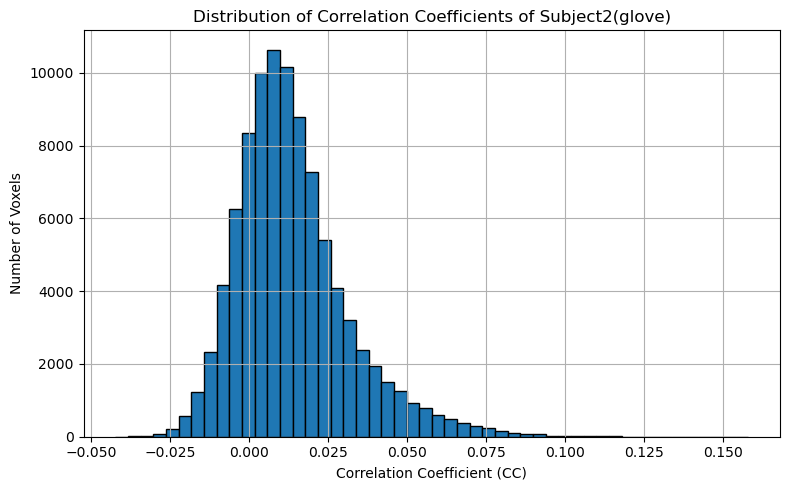

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s2, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject2(glove)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.savefig("../figure/distribution_glv_2.png", dpi=300)
plt.tight_layout()
plt.show()

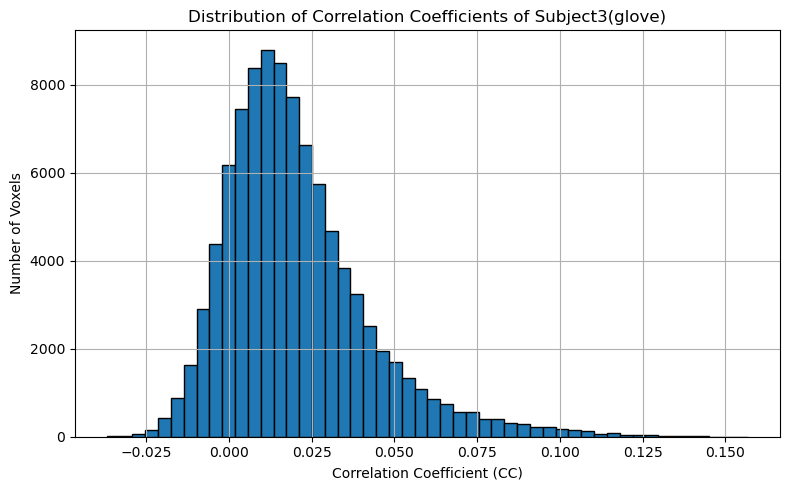

In [28]:
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s3, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject3(glove)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.savefig("../figure/distribution_glv_3.png", dpi=300)
plt.tight_layout()
plt.show()

<h1>stability check<h1>

To perform a stability check, we reshuffle the stories and generate a new train/test split, and compare model performance across different test stories

In [29]:
path_to_data = '/ocean/projects/mth240012p/shared/data'
with open(f'{path_to_data}/raw_text.pkl', 'rb') as f:
    raw_text = pickle.load(f)


random.seed(214)
random.shuffle(all_stories)
split_idx = int(0.7 * len(all_stories))  # 70% for training

train_stories = all_stories[:split_idx]
test_stories = all_stories[split_idx:]

train_stories.sort()
test_stories.sort()

allwords = []
for story in train_stories:
    temp_text = raw_text[story].data
    allwords += temp_text

print(len(allwords))

#compute unique words in train_stories
unique_words = list(set(allwords))
len(unique_words)

130443


9964

In [30]:
glove_file = '../data/glove.6B.300d.txt'

glove_dict = {}
with open(glove_file, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = [float(val) for val in values[1:]]
        glove_dict[word] = vector


in_model = [word for word in unique_words if word in glove_dict]
not_in_model = [word for word in unique_words if word not in glove_dict]
print(f"Percentage of words Not in glv model: {len(not_in_model)/len(unique_words):.4f}")

vector_size = 300 #of pretrained model (Glove)
story_vectors_glv = {} 

for story in train_stories:
    words = raw_text[story].data
    story_vectors_glv[story] = embed_story_words(words, glove_dict, vector_size)

Percentage of words Not in glv model: 0.0452


In [31]:
# downsample and trim matrix
wordseqs = {story: raw_text[story] for story in train_stories}
downsampled_vectors_3 = downsample_word_vectors(
    stories=train_stories,
    word_vectors=story_vectors_glv,
    wordseqs=wordseqs
)

trimmed_vectors_3 = {} #trimmed matrices for each train story 

for story, matrix in downsampled_vectors_3.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_3[story] = trimmed_matrix


# create lagged version of matrices
delayed_vectors_3 = {}

for story, trimmed_matrix in trimmed_vectors_3.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_3[story] = X_lagged

vector_size = 300 #of pretrained model (Glove)
story_vectors_glv_test = {} 

for story in test_stories:
    words = raw_text[story].data
    story_vectors_glv_test[story] = embed_story_words(words, glove_dict, vector_size)

wordseqs2 = {story: raw_text[story] for story in test_stories} #wordseqs for test stories 
downsampled_vectors_3_test = downsample_word_vectors(
    stories=test_stories,
    word_vectors=story_vectors_glv_test,
    wordseqs=wordseqs2
)

trimmed_vectors_3_test = {} #trimmed matrices for each test story 

for story, matrix in downsampled_vectors_3_test.items():
    trimmed_matrix = matrix[5:-10]
    trimmed_vectors_3_test[story] = trimmed_matrix

delayed_vectors_3_test = {}

for story, trimmed_matrix in trimmed_vectors_3_test.items():
    X_lagged = make_delayed(trimmed_matrix, delays=[1, 2, 3, 4])
    delayed_vectors_3_test[story] = X_lagged

print(len(delayed_vectors_3_test))
#check for first matrix for story
for key, value in delayed_vectors_3_test.items():
    print("First key:", key)
    print("delayed matrix for first story is", value.shape)
    break


31
First key: adventuresinsayingyes
delayed matrix for first story is (391, 1200)


In [32]:
import gc
del glove_dict
del raw_text
gc.collect()

0

In [33]:
# subject 2

path_s2 = '/ocean/projects/mth240012p/shared/data/subject2/'
Y_s2_train_dict = {}
for story in train_stories:
    Y_s2_train_dict[story] = np.load(path_s2 + f"{story}.npy")
Y_s2_test_dict = {}
for story in test_stories:
    Y_s2_test_dict[story] = np.load(path_s2 + f"{story}.npy")

#Test for glv, subject 2
# Stack X to make matrix
X_train_full = np.vstack([delayed_vectors_3[s] for s in train_stories]) 
X_test_full = np.vstack([delayed_vectors_3_test[s] for s in test_stories])    

# Stack Y2 to make one matrix
Y_train_s2 = np.vstack([Y_s2_train_dict[s] for s in train_stories])
Y_test_s2 = np.vstack([Y_s2_test_dict[s] for s in test_stories])

logging.basicConfig(level=logging.INFO)
ridge_logger = logging.getLogger("ridge_corr")
zs = lambda v: (v - v.mean(0)) / v.std(0)

X_train_full = zs(X_train_full)
X_test_full = zs(X_test_full)
Y_train_s2 = zs(Y_train_s2)
Y_test_s2 = zs(Y_test_s2)

#subject 2
num_vox_s2 = 94251
corr_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas= np.ones(num_vox_s2))
mean_cc_2 = np.mean(corr_s2[np.isfinite(corr_s2)]) #exclude
print("Mean CC for sub2:", mean_cc_2)



INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23823, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1429.858
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean CC for sub2: 0.005692437195827543


In [34]:
random.seed(214)
np.random.seed(214)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=214)
alphas = np.logspace(1, 4, 10)  # 10 values from 10 to 10000
Rcorrs_folds = []  # Store Rcorrs for each fold

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for glv")

    # Get the story names for this fold
    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_3[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_3[s] for s in val])      
    Y_train = np.vstack([Y_s2_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s2_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 94251)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 94251)
# Select best alpha for each voxel
best_alpha_idx_s2 = np.argmax(Rcorrs_5foldmean, axis=0)  # (94251,)
valphas_s2 = alphas[best_alpha_idx_s2]  # (94251,)


Processing fold 1/5 for glv


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19340, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1272.315
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00422, max corr=0.10336, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00431, max corr=0.10371, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00475, max corr=0.10787, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00602, max corr=0.12123, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00806, max corr=0.13328, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.00973, max corr=0.13539, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01023, max corr=0.13213, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01004, max corr=0.12735, over-und

Processing fold 2/5 for glv


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18892, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1271.734
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00272, max corr=0.08936, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00324, max corr=0.09399, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00414, max corr=0.09707, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00592, max corr=0.10315, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.00858, max corr=0.11236, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01096, max corr=0.12064, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01177, max corr=0.12697, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01159, max corr=0.12587, over-und

Processing fold 3/5 for glv


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18921, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1270.965
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00506, max corr=0.11111, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00549, max corr=0.11110, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00621, max corr=0.10831, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00774, max corr=0.11846, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01013, max corr=0.12703, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01181, max corr=0.12902, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01163, max corr=0.12953, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01080, max corr=0.12487, over-und

Processing fold 4/5 for glv


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19373, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1299.470
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00453, max corr=0.09681, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00527, max corr=0.10076, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00626, max corr=0.10719, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00803, max corr=0.11420, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01053, max corr=0.13534, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01258, max corr=0.13501, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01282, max corr=0.12841, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01217, max corr=0.12232, over-und

Processing fold 5/5 for glv


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18766, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1280.293
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00479, max corr=0.12009, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00527, max corr=0.12217, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00609, max corr=0.12710, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.00778, max corr=0.13798, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01019, max corr=0.13984, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01228, max corr=0.12979, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01300, max corr=0.12138, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01280, max corr=0.11794, over-und

In [35]:
#given valphas, we calculate test CCs on test stories. 
final_ccs_s2 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s2, Y_test_s2, valphas_s2)

valid_ccs_s2 = final_ccs_s2[np.isfinite(final_ccs_s2)]  # Exclude NaNs/infs
mean_cc_s2 = np.mean(valid_ccs_s2)
median_cc_s2 = np.median(valid_ccs_s2)
top_1_percentile_cc_s2 = np.percentile(valid_ccs_s2, 99)  # Top 1 percentile
top_5_percentile_cc_s2 = np.percentile(valid_ccs_s2, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 2 (glv): {mean_cc_s2}")
print(f"Median test CC for subject 2 (glv): {median_cc_s2}")
print(f"Top 1 percentile test CC for subject 2 (glv): {top_1_percentile_cc_s2}")
print(f"Top 5 percentile test CC for subject 2 (glv): {top_5_percentile_cc_s2}")

import gc
del Y_s2_train_dict
del Y_s2_test_dict
del Y_test_s2
del Y_train_s2
del Rcorrs_folds, Rcorrs_5foldmean

gc.collect()

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23823, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1429.858
INFO:ridge_corr:Average difference between actual & assumed Prespvar: nan


Mean test CC for subject 2 (glv): 0.01216856866271903
Median test CC for subject 2 (glv): 0.010172278874434473
Top 1 percentile test CC for subject 2 (glv): 0.05947541790279367
Top 5 percentile test CC for subject 2 (glv): 0.041935887045564176


242

In [36]:
# subject 3
path_s3 = '/ocean/projects/mth240012p/shared/data/subject3/'
Y_s3_train_dict = {}
for story in train_stories:
    Y_s3_train_dict[story] = np.load(path_s3 + f"{story}.npy")
Y_s3_test_dict = {}
for story in test_stories:
    Y_s3_test_dict[story] = np.load(path_s3 + f"{story}.npy")

#Stack Y3 to make one matrix
Y_train_s3 = np.vstack([Y_s3_train_dict[s] for s in train_stories])
Y_test_s3 = np.vstack([Y_s3_test_dict[s] for s in test_stories])
Y_train_s3 = zs(Y_train_s3)
Y_test_s3 = zs(Y_test_s3)

random.seed(214)
np.random.seed(214)

# 5-fold cross-validation on training stories
kf = KFold(n_splits=5, shuffle=True, random_state=214)
alphas = np.logspace(1, 4, 10)  #increase alpha range
Rcorrs_folds = []  # Reset for subject 3

for fold, (train_idx, val_idx) in enumerate(kf.split(train_stories)):
    print(f"Processing fold {fold + 1}/5 for glv (subject 3)")

    train = [train_stories[i] for i in train_idx]  # 56 stories
    val = [train_stories[i] for i in val_idx]      # 14 stories

    # Stack X and Y for this fold
    X_train = np.vstack([delayed_vectors_3[s] for s in train]) 
    X_val = np.vstack([delayed_vectors_3[s] for s in val])      
    Y_train = np.vstack([Y_s3_train_dict[s] for s in train])    
    Y_val = np.vstack([Y_s3_train_dict[s] for s in val])       

    # Z-score 
    X_train = zs(X_train)
    X_val = zs(X_val)
    Y_train = zs(Y_train)
    Y_val = zs(Y_val)

    # Run ridge_corr on this fold
    Rcorrs = ridge_corr(X_train, X_val, Y_train, Y_val, alphas, use_corr=True)
    Rcorrs = np.array(Rcorrs)  # (10, 94251)
    Rcorrs_folds.append(Rcorrs)

# Average Rcorrs across folds
Rcorrs_folds = np.array(Rcorrs_folds)  # (5, 10, 95556)
Rcorrs_5foldmean = Rcorrs_folds.mean(axis=0)  # (10, 95556)

# Select best alpha for each voxel
best_alpha_idx_s3 = np.argmax(Rcorrs_5foldmean, axis=0)  # (95556,)
valphas_s3 = alphas[best_alpha_idx_s3]  # (95556,)



Processing fold 1/5 for glv (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19340, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1272.315
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00983, max corr=0.13065, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01027, max corr=0.13480, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01109, max corr=0.13831, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01308, max corr=0.14547, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01635, max corr=0.15463, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01880, max corr=0.15355, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01879, max corr=0.13942, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01780, max corr=0.13414, over-und

Processing fold 2/5 for glv (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18892, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1271.734
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00855, max corr=0.12357, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00897, max corr=0.12895, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01011, max corr=0.13729, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01289, max corr=0.15203, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01694, max corr=0.16107, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01953, max corr=0.14992, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01926, max corr=0.14271, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01820, max corr=0.13738, over-und

Processing fold 3/5 for glv (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18921, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1270.965
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00843, max corr=0.13832, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.00876, max corr=0.14023, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.00973, max corr=0.14591, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01205, max corr=0.15552, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01561, max corr=0.17522, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01834, max corr=0.17830, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01905, max corr=0.16777, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01852, max corr=0.15865, over-und

Processing fold 4/5 for glv (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (19373, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1299.470
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01071, max corr=0.15668, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01190, max corr=0.16245, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01331, max corr=0.17307, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01559, max corr=0.18919, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01843, max corr=0.19829, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.02003, max corr=0.19096, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01945, max corr=0.17503, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01831, max corr=0.16393, over-und

Processing fold 5/5 for glv (subject 3)


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (18766, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1280.293
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01047, max corr=0.14621, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=21.544, mean corr=0.01124, max corr=0.15888, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01256, max corr=0.17418, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=100.000, mean corr=0.01524, max corr=0.18872, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.01844, max corr=0.18489, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=464.159, mean corr=0.01983, max corr=0.15995, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=1000.000, mean corr=0.01916, max corr=0.14651, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=2154.435, mean corr=0.01826, max corr=0.14821, over-und

In [37]:
# Given valphas, calculate test CCs on test stories
final_ccs_s3 = ridge_corr_pred(X_train_full, X_test_full, Y_train_s3, Y_test_s3, valphas_s3, use_corr=True)

# Compute statistics for subject 3
valid_ccs_s3 = final_ccs_s3[np.isfinite(final_ccs_s3)]  # Exclude NaNs/infs
mean_cc_s3 = np.mean(valid_ccs_s3)
median_cc_s3 = np.median(valid_ccs_s3)
top_1_percentile_cc_s3 = np.percentile(valid_ccs_s3, 99)  # Top 1 percentile
top_5_percentile_cc_s3 = np.percentile(valid_ccs_s3, 95)  # Top 5 percentile

# Print statistics
print(f"Mean test CC for subject 3 (glv): {mean_cc_s3}")
print(f"Median test CC for subject 3 (glv): {median_cc_s3}")
print(f"Top 1 percentile test CC for subject 3 (glv): {top_1_percentile_cc_s3}")
print(f"Top 5 percentile test CC for subject 3 (glv): {top_5_percentile_cc_s3}")

INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (23823, 1200))
INFO:ridge_corr:Training stimulus has LSV norm: 1429.858
INFO:ridge_corr:Average difference between actual & assumed Prespvar: 0.000


Mean test CC for subject 3 (glv): 0.01916593048091734
Median test CC for subject 3 (glv): 0.01566640179882091
Top 1 percentile test CC for subject 3 (glv): 0.08326132350663329
Top 5 percentile test CC for subject 3 (glv): 0.05829899104383568


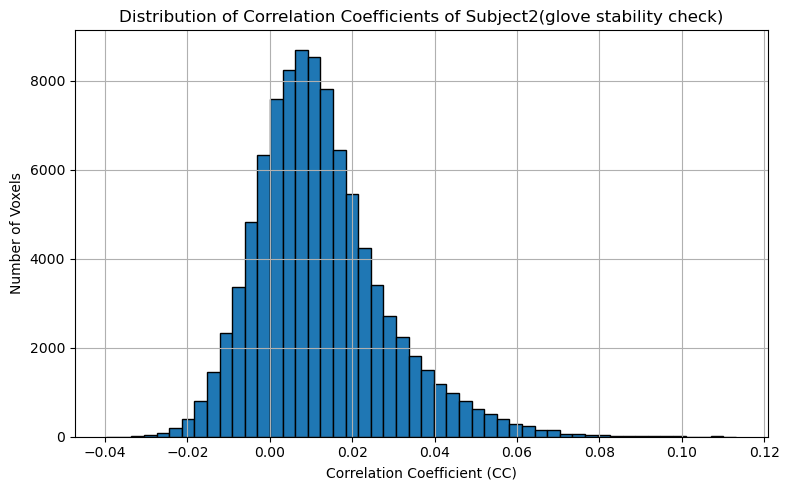

In [38]:
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s2, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject2(glove stability check)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.savefig("../figure/distribution_glv_stability2.png", dpi=300)
plt.tight_layout()
plt.show()

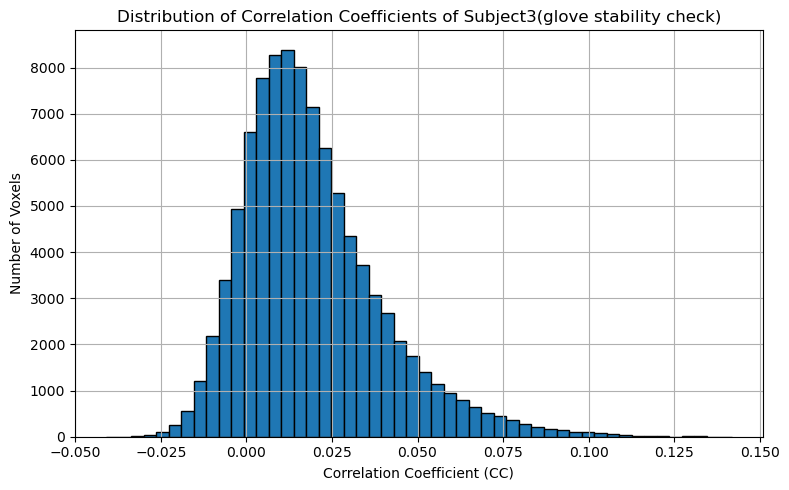

In [39]:
plt.figure(figsize=(8, 5))
plt.hist(valid_ccs_s3, bins=50, edgecolor='black')
plt.title('Distribution of Correlation Coefficients of Subject3(glove stability check)')
plt.xlabel('Correlation Coefficient (CC)')
plt.ylabel('Number of Voxels')
plt.grid(True)
plt.savefig("../figure/distribution_glv_stability3.png", dpi=300)
plt.tight_layout()
plt.show()